<font size="5"><center> **Exercise 3 (Music Transformer)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

#### Based on the 2019 ICLR paper by Cheng-Zhi Anna Huang, Google Brain, and Damon Gwinn's code/repo [GitHub](https://github.com/gwinndr/MusicTransformer-Pytorch)


###Setup Environment and Dependencies. Check GPU.

In [1]:
#@title Check if GPU (driver) is avaiiable (you do not want to run this on CPU, trust me)
# !pip uninstall torch torchvision
# !pip install torch==1.11.0
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Apr 28 08:25:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  7

In [2]:
#@title Clone/Install all dependencies
!git clone https://github.com/asigalov61/midi-neural-processor
!git clone https://github.com/asigalov61/MusicTransformer-Pytorch
!pip install tqdm
!pip install progress
!pip install pretty-midi
!pip install pypianoroll
!pip install matplotlib
!pip install librosa
!pip install scipy
!pip install pillow
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio
!pip install mir_eval
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

Cloning into 'midi-neural-processor'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Receiving objects: 100% (26/26), 8.00 KiB | 8.00 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Cloning into 'MusicTransformer-Pytorch'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 385 (delta 123), reused 107 (delta 107), pack-reused 223
Receiving objects: 100% (385/385), 101.03 KiB | 4.59 MiB/s, done.
Resolving deltas: 100% (204/204), done.
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9614 sha256=4ec893b8f679a4482611ca1396f23da7510bffc9a462695e4b2804ff840448ea
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 20.8 MB/s eta 0:00:

In [3]:
#@title Import all needed modules
import numpy as np
import pickle
import os
import sys
import math
import random
# For plotting
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
#%matplotlib inline
#matplotlib.get_backend()
import mir_eval.display
import librosa
import librosa.display
# For rendering output audio
import pretty_midi
from midi2audio import FluidSynth
from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

In [4]:
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ==> the following two sf2 files should be in the drive
# ==> both of them are submitted
# Import soundfont for Maestro Dataset
piano_soundfont_path = '/content/drive/My Drive/piano.sf2'
piano_soundfont_destination_path = '/content/piano.sf2'
shutil.copyfile(piano_soundfont_path, piano_soundfont_destination_path)
# Import soundfort for Custom Dataset
drums_soundfont_path = '/content/drive/My Drive/drums.sf2'
drums_soundfont_destination_path = '/content/drums.sf2'
shutil.copyfile(drums_soundfont_path, drums_soundfont_destination_path)


Mounted at /content/drive


'/content/drums.sf2'

---

#Option 2: Your own Custom MIDI DataSet (in this case Drums)

In [7]:
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/train'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/test'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/val'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

%cd /content/
!mv midi-neural-processor midi_processor
%cd /content/MusicTransformer-Pytorch/

mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/dataset/e_piano/’: File exists
mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/dataset/e_piano/train’: File exists
mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/dataset/e_piano/test’: File exists
mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/dataset/e_piano/val’: File exists
mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis’: File exists
/content
/content/MusicTransformer-Pytorch


In [9]:
#@title Upload your custom MIDI DataSet (.zip) to created "dataset/e_piano/custom_midis" folder through this cell or manually through any other means. You can also use ready-to-use DataSets below
import zipfile
from google.colab import files

# Specify the destination directory path
destination_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis/'

# Upload the .zip file
uploaded = files.upload()

# Unzip the uploaded file
for filename in uploaded.keys():
    zip_file_path = '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis/' + filename
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)

# Print information about the uploaded file
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving GrooveDrum.zip to GrooveDrum.zip
User uploaded file "GrooveDrum.zip" with length 881498 bytes


For now, we are going to split the dataset by random into "test"/"val" dirs which is not ideal. So feel free to modify the code to your liking to achieve better training results with this implementation.

In [10]:
#@title Process your custom MIDI DataSet :)
%cd /content/MusicTransformer-Pytorch
from processor import encode_midi

import os
import random



%cd '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

custom_MIDI_DataSet_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

train_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/train' # split_type = 0
test_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/test' # split_type = 1
val_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/val' # split_type = 2

total_count = 0
train_count = 0
val_count   = 0
test_count  = 0

f_ext = '.pickle'
fileList = os.listdir(custom_MIDI_DataSet_dir)
for file in fileList:
     # we gonna split by a random selection for now

    split = random.randint(1, 2)
    if (split == 0):
         o_file = os.path.join(train_dir, file+f_ext)
         train_count += 1

    elif (split == 2):
         o_file0 = os.path.join(train_dir, file+f_ext)
         train_count += 1
         o_file = os.path.join(val_dir, file+f_ext)
         val_count += 1

    elif (split == 1):
         o_file0 = os.path.join(train_dir, file+f_ext)
         train_count += 1
         o_file = os.path.join(test_dir, file+f_ext)
         test_count += 1
    try:
      prepped = encode_midi(file)
      o_stream = open(o_file0, "wb")
      pickle.dump(prepped, o_stream)
      o_stream.close()

      prepped = encode_midi(file)
      o_stream = open(o_file, "wb")
      pickle.dump(prepped, o_stream)
      o_stream.close()

      print(file)
      print(o_file)
      print('Coverted!')
    except KeyboardInterrupt:
      raise
    except:
      print('Bad file. Skipping...')

print('Done')
print("Num Train:", train_count)
print("Num Val:", val_count)
print("Num Test:", test_count)
print("Total Count:", train_count)

%cd /content/MusicTransformer-Pytorch

/content/MusicTransformer-Pytorch
/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis
73_jazz_125_fill_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/test/73_jazz_125_fill_4-4.mid.pickle
Coverted!
156_latin-brazilian-baiao_95_fill_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/test/156_latin-brazilian-baiao_95_fill_4-4.mid.pickle
Coverted!
133_funk-fast_125_fill_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/test/133_funk-fast_125_fill_4-4.mid.pickle
Coverted!
11_jazz-funk_116_fill_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/val/11_jazz-funk_116_fill_4-4.mid.pickle
Coverted!
5_jazz-swing_215_beat_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/test/5_jazz-swing_215_beat_4-4.mid.pickle
Coverted!
10_jazz-funk_116_fill_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/test/10_jazz-funk_116_fill_4-4.mid.pickle
Coverted!
131_funk-fast_125_fill_4-4.mid
/content/MusicTransformer-Pytorch/dataset/e_piano/test/131_funk-f

#Train the Model

In [ ]:
#@title Activate Tensorboard Graphs/Stats to monitor/evaluate model perfomance during and after training runs
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime, os
%tensorboard --logdir /content/MusicTransformer-Pytorch/rpr

In [11]:
!pip install torch==1.11.0
# !pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.11.0 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.


In [12]:
#@title Start to Train the Model
batch_size = 2 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 20 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
!python3 train.py -output_dir rpr --rpr -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence #-n_layers -num_heads -d_model -dim_feedforward

Streaming output truncated to the last 5000 lines.
LR: 0.0005139462492034673
Train loss: 1.7989095449447632

Time (s): 0.5369606018066406

Epoch 17  Batch 95 / 178
LR: 0.0005141209420142094
Train loss: 1.7651485204696655

Time (s): 0.5398232936859131

Epoch 17  Batch 96 / 178
LR: 0.0005142956348249516
Train loss: 2.1580464839935303

Time (s): 0.5698165893554688

Epoch 17  Batch 97 / 178
LR: 0.0005144703276356938
Train loss: 2.0724897384643555

Time (s): 0.5520937442779541

Epoch 17  Batch 98 / 178
LR: 0.000514645020446436
Train loss: 1.9417303800582886

Time (s): 0.5421483516693115

Epoch 17  Batch 99 / 178
LR: 0.0005148197132571782
Train loss: 1.952495813369751

Time (s): 0.5533187389373779

Epoch 17  Batch 100 / 178
LR: 0.0005149944060679203
Train loss: 1.9313737154006958

Time (s): 0.5350964069366455

Epoch 17  Batch 101 / 178
LR: 0.0005151690988786625
Train loss: 2.4723927974700928

Time (s): 0.5507349967956543

Epoch 17  Batch 102 / 178
LR: 0.0005153437916894047
Train loss: 1.9541

###Evaluate the resulted models

In [ ]:
#@title Evaluate Best Resulting Accuracy Model (best_acc_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_acc_weights.pickle --rpr

dataset_dir: ./dataset/e_piano
model_weights: rpr/results/best_acc_weights.pickle
n_workers: 1
force_cpu: False

batch_size: 2

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Evaluating:
Avg loss: 2.672972544034322
Avg acc: 0.2897110614511702



In [13]:
#@title Evaluate Best Resulting Loss Model (best_loss_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_loss_weights.pickle --rpr

dataset_dir: ./dataset/e_piano
model_weights: rpr/results/best_loss_weights.pickle
n_workers: 1
force_cpu: False

batch_size: 2

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Evaluating:
Avg loss: 1.8977752923965454
Avg acc: 0.46842953426445405



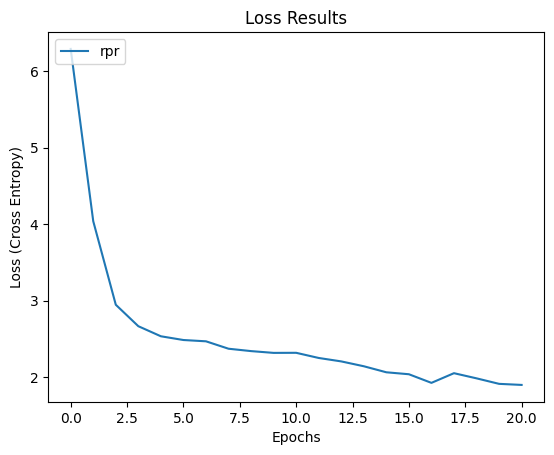

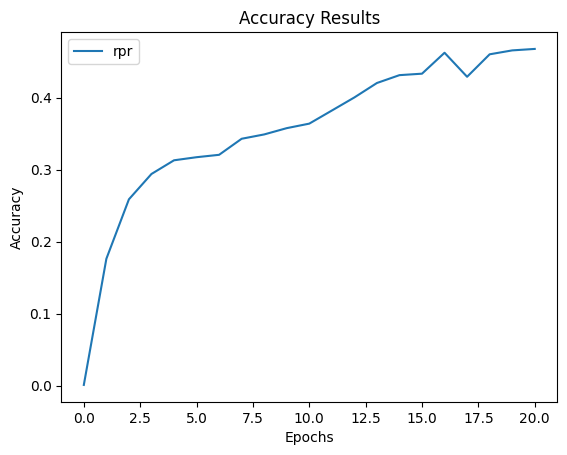

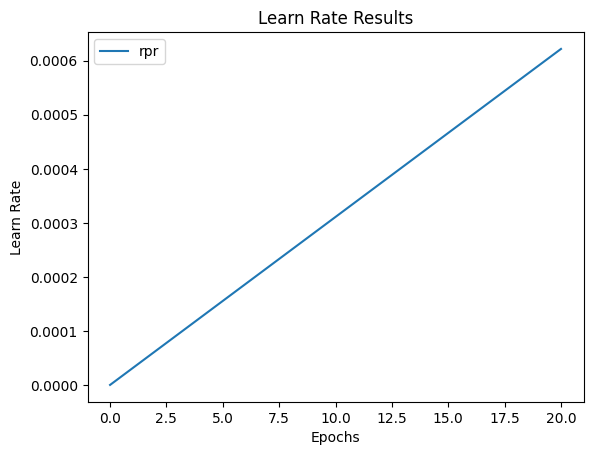

In [14]:
#@title Graph the results
import argparse
import os
import csv
import math
import matplotlib.pyplot as plt

RESULTS_FILE = "results.csv"
EPOCH_IDX = 0
LR_IDX = 1
EVAL_LOSS_IDX = 4
EVAL_ACC_IDX = 5

SPLITTER = '?'


def graph_results(input_dirs="/content/MusicTransformer-Pytorch/rpr/results", output_dir=None, model_names=None, epoch_start=0, epoch_end=None):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Graphs model training and evaluation data
    ----------
    """

    input_dirs = input_dirs.split(SPLITTER)

    if(model_names is not None):
        model_names = model_names.split(SPLITTER)
        if(len(model_names) != len(input_dirs)):
            print("Error: len(model_names) != len(input_dirs)")
            return

    #Initialize Loss and Accuracy arrays
    loss_arrs = []
    accuracy_arrs = []
    epoch_counts = []
    lrs = []

    for input_dir in input_dirs:
        loss_arr = []
        accuracy_arr = []
        epoch_count = []
        lr_arr = []

        f = os.path.join(input_dir, RESULTS_FILE)
        with open(f, "r") as i_stream:
            reader = csv.reader(i_stream)
            next(reader)

            lines = [line for line in reader]

        if(epoch_end is None):
            epoch_end = math.inf

        epoch_start = max(epoch_start, 0)
        epoch_start = min(epoch_start, epoch_end)

        for line in lines:
            epoch = line[EPOCH_IDX]
            lr = line[LR_IDX]
            accuracy = line[EVAL_ACC_IDX]
            loss = line[EVAL_LOSS_IDX]

            if(int(epoch) >= epoch_start and int(epoch) < epoch_end):
                accuracy_arr.append(float(accuracy))
                loss_arr.append(float(loss))
                epoch_count.append(int(epoch))
                lr_arr.append(float(lr))

        loss_arrs.append(loss_arr)
        accuracy_arrs.append(accuracy_arr)
        epoch_counts.append(epoch_count)
        lrs.append(lr_arr)

    if(output_dir is not None):
        try:
            os.mkdir(output_dir)
        except OSError:
            print ("Creation of the directory %s failed" % output_dir)
        else:
            print ("Successfully created the directory %s" % output_dir)

    ##### LOSS #####
    for i in range(len(loss_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], loss_arrs[i], label=name)
        plt.title("Loss Results")
        plt.ylabel('Loss (Cross Entropy)')
        plt.xlabel('Epochs')
        fig1 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig1.savefig(os.path.join(output_dir, 'loss_graph.png'))

    plt.show()

    ##### ACCURACY #####
    for i in range(len(accuracy_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], accuracy_arrs[i], label=name)
        plt.title("Accuracy Results")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'accuracy_graph.png'))

    plt.show()

    ##### LR #####
    for i in range(len(lrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], lrs[i], label=name)
        plt.title("Learn Rate Results")
        plt.ylabel('Learn Rate')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'lr_graph.png'))

    plt.show()
graph_results('/content/MusicTransformer-Pytorch/rpr/results', model_names='rpr')

To have the model continue your custom MIDI enter the following into the custom_MIDI field below:

-primer_file '/content/some_dir/some_seed_midi.mid'

For example: -primer_file '/content/MusicTransformer-Pytorch/seed.mid'

# Generate and Explore the output :)

#### !!! Change the sound font in the following code cell to produce different sounding .wav files. I provide piano.sf2 (by default font.sf2 is piano as well) and drums.sf2 for custom drum dataset that i provide in mega file as well !!!

In [15]:
#@title Generate, Plot, Graph, Save, Download, and Render the resulting output
number_of_tokens_to_generate = 1023 #@param {type:"slider", min:1, max:2048, step:1}
priming_sequence_length = 65 #@param {type:"slider", min:1, max:2048, step:8}
maximum_possible_output_sequence = 2048 #@param {type:"slider", min:0, max:2048, step:8}
select_model = "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle" #@param ["/content/MusicTransformer-Pytorch/rpr/results/best_acc_weights.pickle", "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle"]
custom_MIDI = "" #@param {type:"string"}

import processor
from processor import encode_midi, decode_midi

!python generate.py -output_dir output -model_weights=$select_model --rpr -target_seq_length=$number_of_tokens_to_generate -num_prime=$priming_sequence_length -max_sequence=$maximum_possible_output_sequence $custom_MIDI #

print('Successfully exported the output to output folder. To primer.mid and rand.mid')

# set the src and play
FluidSynth("/content/drums.sf2").midi_to_audio('/content/MusicTransformer-Pytorch/output/rand.mid', '/content/MusicTransformer-Pytorch/output/output.wav')

from google.colab import files
files.download('/content/MusicTransformer-Pytorch/output/rand.mid')
files.download('/content/MusicTransformer-Pytorch/output/primer.mid')

Audio('/content/MusicTransformer-Pytorch/output/output.wav')


midi_root: ./dataset/e_piano/
output_dir: output
primer_file: None
force_cpu: False

target_seq_length: 1023
num_prime: 65
model_weights: /content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle
beam: 0

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Using primer index: 126 ( ./dataset/e_piano/test/141_funk-fast_125_fill_4-4.mid.pickle )
RAND DIST
Generating sequence of max length: 1023
100 / 1023
150 / 1023
200 / 1023
250 / 1023
300 / 1023
350 / 1023
400 / 1023
450 / 1023
500 / 1023
550 / 1023
600 / 1023
650 / 1023
700 / 1023
750 / 1023
800 / 1023
850 / 1023
900 / 1023
950 / 1023
1000 / 1023
info removed pitch: 42
info removed pitch: 37
info removed pitch: 58
info removed pitch: 69
info removed pitch: 51
Successfully exported the output to output folder. To primer.mid and rand.mid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>